In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous
print(X_motion_CoM_continuous.shape)
print(Y_motion_CoM_continuous.shape)

(10027, 28)
(10027, 2)


In [6]:
X_motion_CoM_continuous[0]

array([0.10000000149011612, 0.0, 0.0, 0.06422444087825316,
       0.12709958334894797, 0.02129841568653252, 0.032841687967686085,
       0.007458737822045343, -0.018058522863240344, 0.2349003268785842,
       0.18683081039427935, -0.40515855604189455, 0.23261810624015347,
       -0.20303246525516214, -0.4050806504096208, -0.26129141850751325,
       0.13343324739617787, -0.40023590712089907, -0.2499161232198911,
       -0.15232611895506265, -0.4005353553555561, False, True, True,
       False, 0.10000000149011612, 0.0, 0.0], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [8]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM_continuous[:, 21] == 1)[0]
X_motion_CoM_continuous_FL_RR = X_motion_CoM_continuous[idx_fl_rr_swinging]
Y_motion_CoM_continuous_FL_RR = Y_motion_CoM_continuous[idx_fl_rr_swinging]

In [9]:
idx_fl_rr_swinging.shape

(5005,)

## Predict CoM -> x

In [10]:
X_motion_CoM_continuous_FL_RR[0, :]

array([0.10000000149011612, 0.0, 0.0, 0.09118936918041333,
       -0.17764249841618973, -0.001444254901828773,
       -0.0003798328817117183, 0.02906654879442508, 0.002758206940035604,
       0.21954448416961136, 0.20866494731011204, -0.4047559310040384,
       0.2417546900550716, -0.18419152121884, -0.4052538656619016,
       -0.24350114705582698, 0.1549192331175042, -0.40049584677248623,
       -0.27453523596078333, -0.1273861252788857, -0.4007940233583196,
       True, False, False, True, 0.10000000149011612, 0.0, 0.0],
      dtype=object)

In [11]:
Y_motion_CoM_continuous_FL_RR[0, :]

array([0.010415001640328825, 0.02143068323091371], dtype=object)

### Linear Regression

In [12]:
# Input
X = np.hstack((X_motion_CoM_continuous_FL_RR[:, :3], # motion command
               X_motion_CoM_continuous_FL_RR[:, 3:9],
               X_motion_CoM_continuous_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_continuous_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_continuous_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_continuous_FL_RR[:, 18:20]))

# Labels
Y = np.array([Y_motion_CoM_continuous_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9983034147113067
RMSE:  0.0017888290613705623
The lowest error is:  4.0612559120897784e-07
The highest error is:  0.01697724219429886
The avg. error is:  0.001105475278381837


In [13]:
model_fl_com_x.coef_

array([[ 0.1583681 ,  0.04025599,  0.04330785,  0.00056129,  0.00300335,
         0.06321915, -0.00138429,  0.0037453 , -0.06826527,  0.30538243,
        -0.0686407 ,  0.11815135, -0.2891667 ,  0.10949485, -0.15844472,
         0.21392442,  0.02842542]])

In [14]:
model_fl_com_x.intercept_

array([-0.02424664])

Text(0, 0.5, 'Predictions')

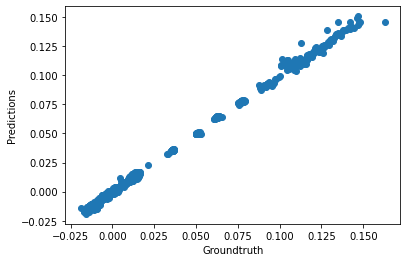

In [15]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [16]:
#%store model_fl_com_x

In [17]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [18]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM foot -> y

### Linear Regression

In [20]:
# Input
X = np.hstack((X_motion_CoM_continuous_FL_RR[:, :3], # motion command
               X_motion_CoM_continuous_FL_RR[:, 3:9],
               X_motion_CoM_continuous_FL_RR[:, 9:11], # FL (x,y) position
               X_motion_CoM_continuous_FL_RR[:, 12:14], # FR (x,y) position
               X_motion_CoM_continuous_FL_RR[:, 15:17], # RL (x,y) position
               X_motion_CoM_continuous_FL_RR[:, 18:20])) 

# Labels
Y = np.array([Y_motion_CoM_continuous_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9969991411000474
RMSE:  0.0018181155393259963
The lowest error is:  3.749628839297414e-07
The highest error is:  0.015202354988888084
The avg. error is:  0.001175172250931222


In [21]:
model_fl_com_y.coef_

array([[ 0.01937409,  0.19852968,  0.06716851, -0.00271488, -0.00098713,
         0.0955618 , -0.00339751, -0.0140157 , -0.10065062,  0.04418614,
         0.13699184, -0.0732032 , -0.14528297, -0.09966058, -0.0176591 ,
        -0.05120565,  0.30746906]])

In [22]:
model_fl_com_y.intercept_

array([-0.02464283])

Text(0, 0.5, 'Predictions')

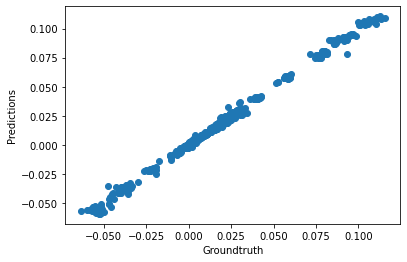

In [23]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [58]:
#%store model_fl_com_y

In [59]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [60]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")